## Access Landsat Images 
#### In the this notebook we will look at how to use python to open, Visualise and Pre-processes Landsat 8 Images remote sensing satellite images

#### Load required python packages

In [1]:
import glob
import rasterio
from rasterio.mask import mask
from skimage import exposure
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import gdal, ogr, osr, os

#### Get image files from folders 

In [6]:
Img_files = glob.glob('/vault/projects/sustainable-agriculture/landsat8_Images/*band*')
Img_files[:10]

['/vault/projects/sustainable-agriculture/landsat8_Images/LC08_L1TP_175083_20150802_20180526_01_T1_sr_band7.tif',
 '/vault/projects/sustainable-agriculture/landsat8_Images/LC08_L1TP_175083_20150122_20170413_01_T1_sr_band6.tif',
 '/vault/projects/sustainable-agriculture/landsat8_Images/LC08_L1TP_175083_20140308_20170425_01_T1_sr_band5.tif',
 '/vault/projects/sustainable-agriculture/landsat8_Images/LC08_L1TP_175083_20151005_20170403_01_T1_sr_band4.tif',
 '/vault/projects/sustainable-agriculture/landsat8_Images/LC08_L1TP_175083_20141002_20180526_01_T1_sr_band4.tif',
 '/vault/projects/sustainable-agriculture/landsat8_Images/LC08_L1TP_175083_20151005_20170403_01_T1_sr_band6.tif',
 '/vault/projects/sustainable-agriculture/landsat8_Images/LC08_L1TP_175083_20150802_20180526_01_T1_sr_band3.tif',
 '/vault/projects/sustainable-agriculture/landsat8_Images/LC08_L1TP_175083_20150802_20180526_01_T1_sr_band6.tif',
 '/vault/projects/sustainable-agriculture/landsat8_Images/LC08_L1TP_175083_20150122_2017

In [3]:
Img_QA_files = glob.glob('/vault/projects/sustainable-agriculture/landsat8_Images/*2018*pixel_qa*')
Img_QA_files[:7]

['/Volumes/Edd_Passport/landsat_8_files/L8_Unziped/LC08_L1TP_175083_20141002_20180526_01_T1_pixel_qa.tif',
 '/Volumes/Edd_Passport/landsat_8_files/L8_Unziped/LC08_L1TP_175083_20150327_20180526_01_T1_pixel_qa.tif',
 '/Volumes/Edd_Passport/landsat_8_files/L8_Unziped/LC08_L1TP_175083_20150412_20180526_01_T1_pixel_qa.tif',
 '/Volumes/Edd_Passport/landsat_8_files/L8_Unziped/LC08_L1TP_175083_20150802_20180526_01_T1_pixel_qa.tif',
 '/Volumes/Edd_Passport/landsat_8_files/L8_Unziped/LC08_L1TP_175083_20151224_20180526_01_T1_pixel_qa.tif',
 '/Volumes/Edd_Passport/landsat_8_files/L8_Unziped/LC08_L1TP_175083_20160414_20180526_01_T1_pixel_qa.tif',
 '/Volumes/Edd_Passport/landsat_8_files/L8_Unziped/LC08_L1TP_175083_20151021_20180526_01_T1_pixel_qa.tif']

In [4]:
# name_date['Date'] = pd.to_datetime(name_date.Date, format='%Y%j')

#### Open individual image bands and get meta data (Coordinate Reference System, Image bounds) about the images

In [7]:
blue_bnd = rasterio.open(Img_files[1]) # Open the Blue band
green_bnd = rasterio.open(Img_files[2]) # Open the Green band
red_bnd = rasterio.open(Img_files[3]) # Open the Red band
nir_bnd = rasterio.open(Img_files[4]) # Open the Near Infra-Red band

#### See the meta data infomation for the blue band

In [8]:
# Get meta data info

meta = blue_bnd.meta 

# Get image boundaries
img_bounds = blue_bnd.bounds 

#Calculate image pixel resolution using bounds info
img_res = (blue_bnd.bounds.right - blue_bnd.bounds.left)/(blue_bnd.width)

print('Meta Info\n==================\n{}\nBounds Info\n==================\n{}\nImage Resolution\n==================\n{}m\n'.format(meta, img_bounds, img_res))

Meta Info
{'driver': 'GTiff', 'dtype': 'int16', 'nodata': -9999.0, 'width': 7661, 'height': 7711, 'count': 1, 'crs': CRS.from_epsg(32634), 'transform': Affine(30.0, 0.0, 191985.0,
       0.0, -30.0, -3557385.0)}
Bounds Info
BoundingBox(left=191985.0, bottom=-3788715.0, right=421815.0, top=-3557385.0)
Image Resolution
30.0m



#### Read individual image bands as arrays. 
##### Once and image read as an array, one can apply any array funtion to the image and save it back as an image file 
##### It is important to note that Image reflectance or pixel values are captured and stored as INT16 (16-bit signed integer) thus it must be scaled by a factor of 0.0001 before use.

In [9]:
# Read each band as array and scale by a factor of 0.0001
red_img = red_bnd.read(1)*0.0001
blue_img = blue_bnd.read(1)*0.0001
green_img = green_bnd.read(1)*0.0001
nir_img = nir_bnd.read(1)*0.0001

## Visualize Landsat Images 

In [10]:
# Function to plot images 
def plotImg(array, fsize):
    plt.figure(figsize=(fsize,fsize))
    img = plt.imshow(array)

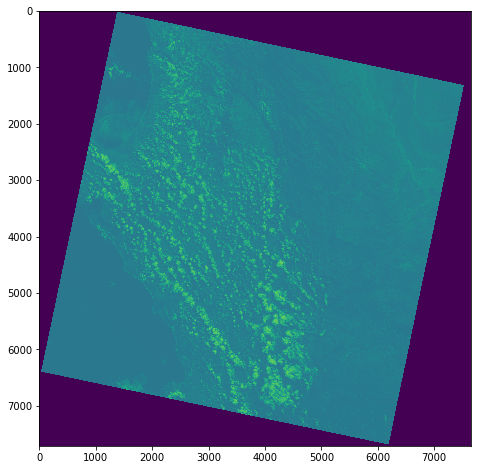

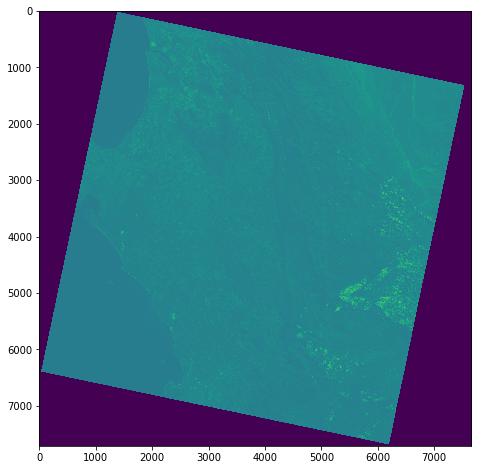

In [11]:
#Plot red band and Near Infra-Red Band image
plotImg(red_img, 8)
plotImg(nir_img, 8)

#### Creating image composites 
##### Because the image have been converted to arrays numpy stacking can be used to create various composites

In [10]:
# Create true colour composite
rgb = np.dstack((red_img, green_img, blue_img))

# Create false colour composite
ngr = np.dstack((nir_img, green_img, red_img))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


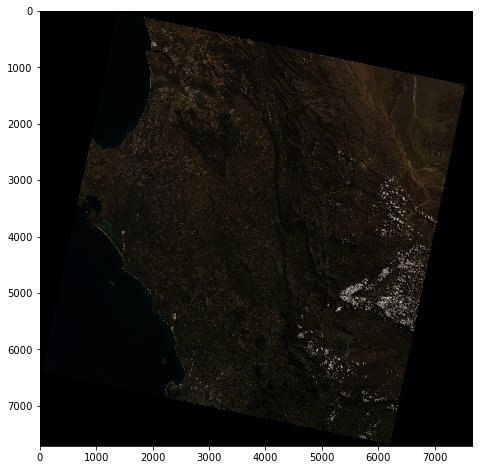

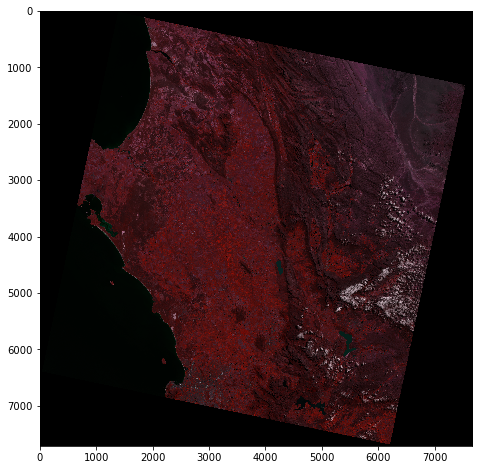

In [11]:
#Plot red band and Near Infra-Red Band image
plotImg(rgb, 8)
plotImg(ngr, 8)

##### The images apprear to dark thus the need to enhance the contrast (make it brighter)
##### The "exposure" function from the in Skimage package will used to enhance the image contrast

In [12]:
better_rgb = exposure.rescale_intensity(rgb, in_range=(0, 0.35))

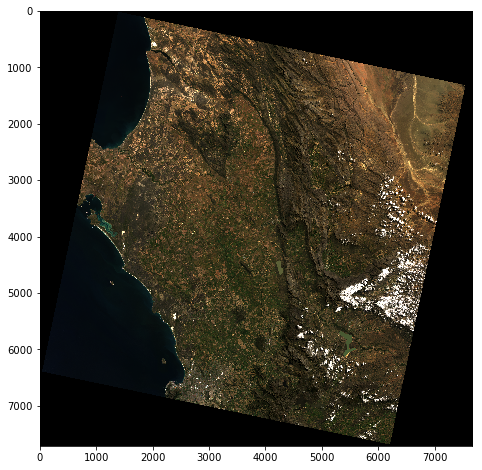

In [13]:
plotImg(better_rgb, 8)

##### Slice image arrays to zoom in an area of interest

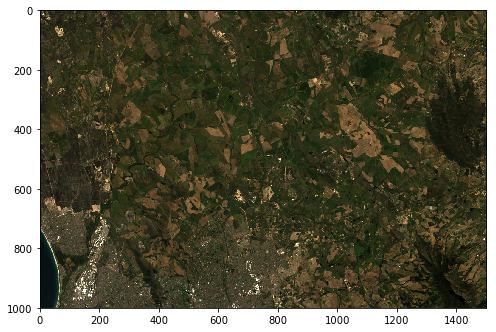

In [14]:
plotImg(better_rgb[5500:6500,2500:4000], 8)

In [15]:
# Try other composites and enhance image contrast

### Dealing with cloud and cloud shadows
##### Pixels flags in the quality assurance(QA) map files will be used to mask out clouds, cloud shadows and other unclear pixels. The flags for different QA levels can be found in the Landsat Product document (Page 11, Table 6-3)

In [16]:
# Read in the QA file with same date (Year, Month and Day of Aquisition)
qa_file = rasterio.open(Img_QA_files[0]) # Open the QA file
qa_array = qa_file.read(1) # Read the QA image as array

##### The QA flags that indicate clear quality pixels are used mask out low quality pixels.

In [17]:
qflag= [322, 386, 834, 898, 1346] # QA array numbers that indicate clear pixels
clear_flags = np.isin(qa_array, qflag ) # Remove all non clear pixel flags and keep clear pixels
red_masked = np.ma.array(red_img,mask=clear_flags-1) # Mask red band array
nir_masked = np.ma.array(nir_img,mask=clear_flags-1) # Mask nir band array
red = red_masked.filled(np.nan) # Convert red masked array to 2D array
nir = nir_masked.filled(np.nan) # Convert red masked array to 2D array

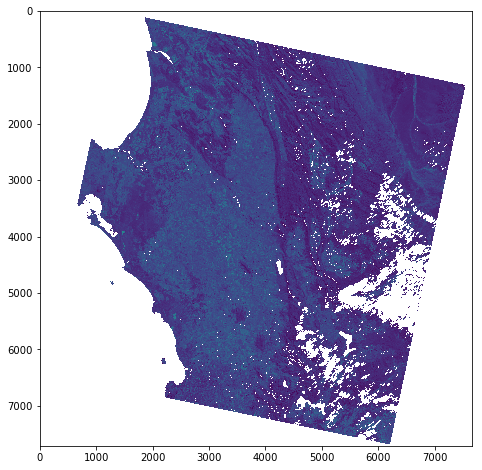

In [18]:
plotImg(nir, 8)

### Calculate Vegetation Indices (Normalized Difference Vegetation Index (NDVI))
##### NDVI is the index the detection and identification of green vegetation in the EO image. It red and near infra-red bands are combined to get the NDVI (NDVI = NIR - Red/NIR + Red)

In [19]:
# Put the red band and NIR band array into the NDVI formula
ndvi = (nir-red)/(nir+red)

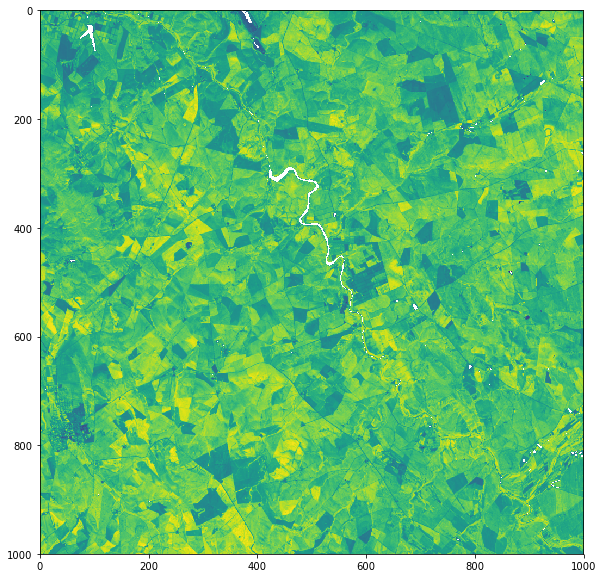

In [20]:
plotImg(ndvi[3000:4000,3000:4000], 10)